## 实用工具

In [61]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    
    return {
        "messages": [
            ToolMessage(
                content=f"错误： {repr(error)}\n 请修正你的错误。",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("当前状态: ", current_state[-1])
    message = event.get("messages")
    if message:
        print(message)
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (截断)"
            print(msg_repr)
            _printed.add(message.id)

In [62]:
from langchain_core.tools import tool


# def get_weahter(location):
#    if location=="Shanghai":
#        return "sunny"
#    elif location=="Beijing":
#        return "rainy"
#    else:
#        return f"I don't know the weahter of location {location}"
@tool
def get_weahter(location:str,food:str, parse_docstring=True):
    '''定义当前城市的天气'''
    if location == "Shanghai":
        return f"It's sunny in {location} with {food}"
    elif location == "Beijing":
        return f"It's rainy in {location} with {food}."
    else:
        return f"I don't know the weather of {location} with {food}."

#定义第二个工具的函数实现,该工具能够实现输入一个地名，返回一句话我已经订好票了并且在周四的时候去这个地方玩
@tool

def get_visiting_place(visiting_place:str, parse_docstring=True):
    '''定义当前城市的可以去玩的地方'''
    return f'I have order the ticket and we will go {visiting_place} on Thursday.'


@tool
def School(school_name:str,degree:str, parse_docstring=True):
    '''获取想申请目标学校名称和学位（本科，博士，硕士，研究生...）'''
    return school_name,degree
@tool
def chat_round(his_school_name:str,major:str,GPA:str, parse_docstring=True):
    '''(1) 您目前就读于国内哪个学校哪个专业？
    (2) 您当前的GPA是多少？'''
    return his_school_name,major,GPA

#定义大模型调用工具的schema(工具的定义)
#tools=[get_weahter,get_visiting_place]

In [63]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages
OPENAI_API_KEY= "sk-ihk5obdasfaV10econ8bhfUiKroVr8cTnU1C1qJua8VVWygg"
TAVILY_API_KEY='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'
LANGCHAIN_API_KEY='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'
#os.environ['TAVILY_API_KEY']='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'
import os
os.environ["LANGCHAIN_PROJECT"] = f"Langrah_旅游资讯机器人客服"
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ['USER_AGENT'] = 'myagent'
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]



from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from datetime import datetime  # 添加了 datetime.now 缺少的导入


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # 如果LLM返回空响应，我们将重新提示它
            # 以获取实际响应。
            if not result.tool_calls and (
                    not result.content
                    or isinstance(result.content, list)
                    and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "请给出实际输出。")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


llm = ChatOpenAI(model="gpt-4.1",base_url="https://api.302.ai/v1/chat/completions",api_key="sk-gPl43py4bj6TN3mksIN18FPbRZXdHoV6i0XOAAshKFpanIb1")

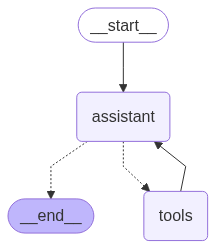

In [65]:
# from langchain_tavily import TavilySearch

# tools=[get_weahter,get_visiting_place]
# tools=[School,chat_round]
# primary_assistant_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "你是一名旅游助理。 "
#             " 使用提供的工具搜当地的天气和旅游景点查询。 "
#             " 搜索时要坚持不懈 "
#             " 如果搜索结果为空，请在放弃前扩大搜索范围。"
#             "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
#             "\nCurrent time: {time}.",
#         ),
#         ("placeholder", "{messages}"),
#     ]
# ).partial(time=datetime.now)
from langchain_core.tools import Tool
a = [
        Tool(name="add_one", func=School, description="提取学校和学位操作"),
        Tool(name="chat_round", func=chat_round, description="提取目前学校和GPA操作"),
    ]
tools_=[School,chat_round]
tools = ToolNode(a).with_fallbacks(
    [RunnableLambda(handle_tool_error)], exception_key="error"
)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "你是一名留学主力。 "
                " 使用提供的工具提取需要申请的学校，学位 ，以及当前就读的学校和专业以及GPA "
                " 搜索时要坚持不懈 "
                " 如果搜索结果为空，请在放弃前扩大搜索范围。"
                "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
                "\nCurrent time: {time}.",
            ),
            ("placeholder", "{messages}"),
        ]
    ).partial(time=datetime.now)
part_1_assistant_runnable = primary_assistant_prompt| llm.bind_tools(tools_)

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# 定义节点：这些节点完成工作
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", (tools))
# 定义边：这些决定了控制流如何移动
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
from IPython.display import Image, display
# 检查点使图保持其状态
# 这是整个图的完整内存。
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)
display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))

In [66]:
tutorial_questions=["博士"]
config = {
    "configurable": {
        # passenger_id 用于我们的航班工具
        # 以获取用户的航班信息
        "passenger_id": "3442 587242",
        # 检查点通过 thread_id 访问
        "thread_id": '1234565',
    }
}
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("当前状态: ", current_state[-1])
    message = event.get("messages")
    if message:
        # print(message[1].additional_kwargs['tool_calls'])
        # print(100*'-')
       
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (截断)"
            print('输出',msg_repr)
            _printed.add(message.id)

_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        # print(event)
        _print_event(event, _printed)

输出 ================================ Human Message =================================

博士
输出 ================================== Ai Message ==================================

请提供以下信息，以便我帮您更好地提取和搜索相关内容：

1. 您目前就读的学校名称是什么？
2. 您的专业是什么？
3. 您当前的GPA是多少？
4. 您计划申请哪些博士项目或目标学校名称？

如果您不确定目标学校或专业，也可以告诉我您的大致意向/方向，我会帮您补充搜索。


In [59]:
tutorial_questions=["我想申请美国麻省理工学院的申请"]
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        # print(event)
        _print_event(event, _printed)

输出 ================================ Human Message =================================

我想申请美国麻省理工学院的申请
输出 ================================== Ai Message ==================================
Tool Calls:
  School (call_1R1hgGthokz11PbIyqUGONtS)
 Call ID: call_1R1hgGthokz11PbIyqUGONtS
  Args:
    degree: 博士
    school_name: 麻省理工学院
输出 ================================= Tool Message =================================
Name: School

["麻省理工学院", "博士"]
输出 ================================== Ai Message ==================================

你想申请的是美国麻省理工学院（MIT）的博士学位。为更好地帮助你准备申请，请提供你目前就读的学校名称、你的专业以及当前的GPA。这些信息对申请材料整理和后续咨询非常重要。
